Camacho Castelan Jose Manuel
S22002245

In [1696]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import igraph
from igraph import Graph, EdgeSeq
import plotly.graph_objects as go
import math
import random

In [1697]:
mov = 0.5 # tamanio de paso del robot
expandidos = []

origen = [5,0]
meta = [8,8]

In [1698]:
def get_nodos(raiz):
    nodos = []
    por_visitar = [raiz]
    visitados = []

    while por_visitar != []:
        nodo = por_visitar.pop(0)
        if (nodo in visitados) or (nodo in nodos):
            continue
        nodos.append(nodo)
        por_visitar += nodo.hijos
        visitados.append(nodo)

    return nodos

In [1699]:
def get_etiquetas(nodos):
    labels = []
    for nodo in nodos:
        labels.append(
            str(nodo.pos)
        )
    return labels

In [1700]:
def crear_grafo(nodos, etiquetas):
    
    g = Graph(directed = True)

    for nodo in nodos:
        g.add_vertex(etiquetas[nodos.index(nodo)])
    padre_hijo = []
    for nodo in nodos:
        
        padre_hijo.append([nodo.papa, nodo])
    for r in padre_hijo:
        if r[0]:  # tiene papa
            g.add_edge(etiquetas[nodos.index(r[0])], etiquetas[nodos.index(r[1])])

    edges = [e.tuple for e in g.es]
    
    return g, edges

In [1701]:
def dibujar_grafo(grafo, labels, title):
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        return f"SHay {len(raices)}, imposible ejecutar"
    root_idx = raices[0]

    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx]) # out, que no se graficque hacia los lados, sino hacia abajo

    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]  # y negativa: hacia abajo

    Xe, Ye = [], []
    for edge in grafo.get_edgelist():
        Xe += [Xn[edge[0]], Xn[edge[1]], None]
        Ye += [Yn[edge[0]], Yn[edge[1]], None]

    trace_edges = go.Scatter(
        x=Xe, y=Ye,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none"
    )

    trace_nodes = go.Scatter(
        x=Xn, y=Yn,
        mode="markers",
        marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
        text=labels,
        textposition="middle center",
        hoverinfo="text"
    )

    fig = go.Figure(data=[trace_edges, trace_nodes],
                    layout=go.Layout(title=title,
                                     showlegend=True,
                                     margin=dict(b=20, l=5, r=5, t=40),
                                     xaxis=dict(showgrid=False, zeroline=False),
                                     yaxis=dict(showgrid=False, zeroline=False)))
    fig.show()

In [1702]:
def dibujar_grafo_anim(grafo, labels, title):
    raices = [v.index for v in grafo.vs if grafo.degree(v, mode="in") == 0]
    if len(raices) != 1:
        raise ValueError(f"Se esperaba 1 raíz, pero hay {len(raices)}")

    root_idx = raices[0]
    layout = grafo.layout_reingold_tilford(mode="out", root=[root_idx])
    Xn = [pos[0] for pos in layout]
    Yn = [-pos[1] for pos in layout]

    # Preparar nodos y aristas para cada frame
    frames = []
    num_nodos = len(grafo.vs)
    for i in range(1, num_nodos + 1):
        # Aristas visibles hasta este nodo
        Xe, Ye = [], []
        for edge in grafo.get_edgelist():
            if edge[0] < i and edge[1] < i:
                Xe += [Xn[edge[0]], Xn[edge[1]], None]
                Ye += [Yn[edge[0]], Yn[edge[1]], None]

        trace_edges = go.Scatter(
            x=Xe, y=Ye,
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none"
        )

        trace_nodes = go.Scatter(
            x=Xn[:i], y=Yn[:i],
            mode="markers",
            marker=dict(symbol="circle-dot", size=30, color="lightblue", line=dict(width=2)),
            text=labels[:i],
            textposition="middle center",
            hoverinfo="text"
        )

        frames.append(go.Frame(data=[trace_edges, trace_nodes], name=str(i)))

    # Frame inicial
    initial_edges = go.Scatter(x=[], y=[], mode="lines")
    initial_nodes = go.Scatter(x=[], y=[], mode="markers")

    fig = go.Figure(
        data=[initial_edges, initial_nodes],
        layout=go.Layout(
            title=title,
            showlegend=True,
            margin=dict(b=20, l=7, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False),
            updatemenus=[dict(
                type="buttons",
                buttons=[dict(label=" > Reproducir",
                              method="animate",
                              args=[None, {"frame": {"duration": 500, "redraw": True},
                                           "fromcurrent": True, "transition": {"duration": 0}}])],
                showactive=False,
                x=0.1, y=-0.1
            )]
        ),
        frames=frames
    )

    fig.show()

In [1703]:
def dibujar(gp):
    plt.grid(True)
    plt.scatter(gp[0], gp[1], c="r") # dibula la posicion del punto
    plt.plot([0,0,10, 10,0], [0,10,10,0,0], c="k") # dibujamos un cuadro delimitando el espacio de trabajo

In [1704]:
class Obstaculo():
    def __init__(self, v1, v2):
        self.v1 = v1 # esquina superior
        self.v2 = v2 # esquina inferior

    def en_colision(self, punto):
        if self.v1[0] <= punto[0] <= self.v2[0] and self.v2[1] <= punto[1] <= self.v1[1]:
            return True
        return False
    
    def dibuja(self):
        x = [self.v1[0], self.v2[0], self.v2[0], self.v1[0], self.v1[0]]
        y = [self.v1[1], self.v1[1], self.v2[1], self.v2[1], self.v1[1]]
        plt.plot(x,y, "--k")

In [1705]:
obstaculos = [
    Obstaculo([6,7],[7.5,2]),
    Obstaculo([5,9],[7,7]),
    Obstaculo([4,6],[5,4]),
    Obstaculo([7.5,6],[8.5,2]),
    Obstaculo([2,6],[3,4]),
    Obstaculo([2,3],[2.5,2]),
    Obstaculo([2,2.5],[4.5,2]),

]

In [1706]:
def es_punto_valido(punto, obstaculos, limites):
    # esta en el limite permitido?
    if limites[0] <= punto[0] <= limites[2] and limites[1] <= punto[1] <= limites[3] :
        # Hay colision
        for o in obstaculos:
            if o.en_colision(punto):
                return False
        return True
    return False

In [1707]:
class Nodo():
    def __init__(self, pos, papa = None):
        global expandidos
        self.pos = pos
        self.hijos = []
        self.papa = papa
        if self not in expandidos:
            expandidos.append(self)

    def genera_hijos(self, obstaculos, limites):
        global expandidos
        
        # uno arriba
        pos_arriba = self.pos[:]
        pos_arriba[1] += mov

        # uno abajo
        pos_abajo = self.pos[:]
        pos_abajo[1] -= mov
        
        # uno izq
        pos_izq = self.pos[:]
        pos_izq [0] -= mov
        
        # uno der
        pos_der = self.pos[:]
        pos_der[0] += mov
        
        if es_punto_valido(pos_arriba, obstaculos, limites):
            hijo = self.__class__(pos_arriba, self)
            self.hijos.append(hijo)

        if es_punto_valido(pos_abajo, obstaculos, limites):
            hijo = self.__class__(pos_abajo, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_izq, obstaculos, limites):
            hijo = self.__class__(pos_izq, self)
            self.hijos.append(hijo)
        
        if es_punto_valido(pos_der, obstaculos, limites):
            hijo = self.__class__(pos_der, self)
            self.hijos.append(hijo)

    def __eq__(self, n2):
        return self.pos == n2.pos

    def __str__(self):
        s = f"{self.pos[0]}, {self.pos[1]}"
        return s

    def rrt(self, meta, robot, max_iter=1000):
        global expandidos
        nodos = [self]
        for i in range(max_iter):
            # Generar un punto aleatorio en el espacio
            rand_x = random.randint(robot.limites[0], robot.limites[2])
            rand_y = random.randint(robot.limites[1], robot.limites[3])
            punto_random = [rand_x, rand_y]
            print(f"punto_random {punto_random}")

            # Encontrar el nodo más cercano al punto aleatorio
            nodo_cercano = min(nodos, key=lambda n: math.dist(n.pos, punto_random))
            print(f"nodo_cercano {nodo_cercano}")

            # Moverse desde el nodo cercano hacia el punto aleatorio
            direccion = np.array(punto_random) - np.array(nodo_cercano.pos)
            print(f"direccion {direccion}")

            longitud = np.linalg.norm(direccion)
            print(f"longitud {longitud}")

            if longitud == 0:
                continue
            direccion = (direccion / longitud) * mov  # Tamaño de paso
            print(f"direccion {direccion}")
            
            nuevo_punto = list(np.array(nodo_cercano.pos) + direccion)
            print(f"nuevo_punto {nuevo_punto}")


            # Verificar si el nuevo punto es válido
            if es_punto_valido(nuevo_punto, robot.obstaculos, robot.limites):
                nuevo_nodo = Nodo(nuevo_punto, nodo_cercano)
                nodo_cercano.hijos.append(nuevo_nodo)
                nodos.append(nuevo_nodo)
                expandidos.append(nuevo_nodo)

                # Verificar si estamos cerca de la meta
                if math.dist(nuevo_punto, meta) < mov:
                    meta_nodo = Nodo(meta, nuevo_nodo)
                    nuevo_nodo.hijos.append(meta_nodo)
                    nodos.append(meta_nodo)
                    expandidos.append(meta_nodo)

                    # Reconstruir el camino
                    camino = []
                    actual = meta_nodo
                    while actual:
                        camino.append(actual)
                        actual = actual.papa
                    camino.reverse()
                    return camino # Camino desde raíz hasta meta
        return []  # No se encontró camino

        
    def rrt2(self, meta, robot, max_iter=1000):
        global expandidos
        camino = [self]

        def trayectoria_valida(a, b):
            dx = abs(a[0] - b[0])
            dy = abs(a[1] - b[1])
            pasos = int(max(dx, dy) * 2)  # mayor resolución si mov=2

            puntos = []
            for i in range(pasos + 1):
                x = a[0] + (b[0] - a[0]) * i / pasos
                y = a[1] + (b[1] - a[1]) * i / pasos
                punto = [round(x), round(y)]

                if es_punto_valido(punto, robot.obstaculos, robot.limites):
                    puntos.append(punto)
                else:
                    return False  # Si un punto no es válido, descartamos todo
            return puntos  # Trayectoria completa válida

        iteraciones = 0
        while iteraciones < max_iter:
            iteraciones += 1
            # Generar punto aleatorio en el espacio
            r_p = [random.randint(robot.limites[0], robot.limites[2]),
                random.randint(robot.limites[1], robot.limites[3])]

            # Intentar conectar el último punto del camino hacia el aleatorio
            puntos_trayectoria = trayectoria_valida(camino[-1].pos, r_p)
            if puntos_trayectoria:
                nuevo_nodo = Nodo(r_p, camino[-1])
                expandidos.append(nuevo_nodo)
                camino.append(nuevo_nodo)

                # Si se puede llegar desde este nuevo nodo a la meta, finalizamos
                if trayectoria_valida(r_p, meta):
                    camino.append(Nodo(meta, camino[-1]))
                    return camino

        print("No se encontró un camino en", max_iter, "iteraciones.")
        return camino  # Puede estar incompleto


In [1708]:
class Robot():
    def __init__(self, pos = [5,5], limites = [0,0,10,10], obstaculos = []):
        self.pos = pos
        self.limites = limites
        self.obstaculos = obstaculos
        self.trajectory = []
        self.raiz = Nodo(pos)

        if self.raiz not in expandidos:
            expandidos.append(self.raiz)
    
    def agrega_obstaculo(self, obs):
        self.obstaculos.append(obs)

    def plot_robot(self):
        plt.scatter(self.pos[0], self.pos[1], c="b")

    def RRT(self):
        self.raiz = Nodo(self.pos)
        camino = self.raiz.rrt(meta, self)
        self.trajectory = []
        for paso in camino:
            self.trajectory += paso.pos
        return camino
    
    def RRT2(self):
        self.raiz = Nodo(self.pos)
        camino = self.raiz.rrt2(meta, self)
        self.trajectory = []
        for paso in camino:
            self.trajectory += paso.pos
        return camino
    
        

In [1709]:
def plot_space_simple(robot, expandidos, title):
    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    robot.plot_robot()

    for p in expandidos:
        plt.scatter(p.pos[0], p.pos[1], c="k")

    plt.plot(robot.trajectory[0::2], robot.trajectory[1::2], "o-b")

    dibujar([8,8])

    plt.title(title)
    plt.grid(visible=True)


In [1710]:
def plot_space_animado(robot, expandidos, title):
    # Creamos la figura y los ejes
    fig, ax = plt.subplots()

    x_points = robot.trajectory[0::2]
    y_points = robot.trajectory[1::2]
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)

    for obstaculo in robot.obstaculos:
        obstaculo.dibuja()
    

    # Línea inicial vacía
    line, = ax.plot([], [], "o-b")
    exp = ax.scatter([], [])
    


    # Función de inicialización
    def init():
        line.set_data([], [])
        exp.set_offsets(np.empty((0, 2)))
        dibujar(meta)
        robot.plot_robot()
        return line,

    def update(frame):

        x_data = x_points[:frame]
        y_data = y_points[:frame]
        line.set_data(x_data, y_data)

        x_exp = []
        y_exp = []

        porcentaje = frame / len(x_points)
        num_expandidos = int(len(expandidos) * porcentaje)

        for nodo in expandidos[:num_expandidos]:
            x_exp.append(nodo.pos[0])
            y_exp.append(nodo.pos[1])
        exp.set_color("y")
        exp.set_offsets(np.c_[x_exp, y_exp])
        
        return line, exp

    # Creamos la animación
    ani = FuncAnimation(
        fig, update, frames=len(x_points),
        init_func=init, blit=True, interval=100
    )

    plt.title(title)
    plt.grid(visible=True)
    # Mostramos la animación
    plt.show()

In [1711]:
def ejecutar_RRT():
    expandidos = []  # Limpiar nodos expandidos
    robot = Robot(pos=origen, limites=[0, 0, 10, 10], obstaculos=obstaculos)
    camino = robot.RRT()
    for nodo in camino:
        print(nodo)

    # Dibuja el espacio y la trayectoria
    plot_space_simple(robot, expandidos, "RRT - Espacio simple")
    # O animación
    plot_space_animado(robot, expandidos, "RRT - Animado")

In [1712]:
def ejecutar_RRT2():
    expandidos = []  # Limpiar nodos expandidos
    robot = Robot(pos=origen, limites=[0, 0, 10, 10], obstaculos=obstaculos)
    camino = robot.RRT2()

    # Dibuja el espacio y la trayectoria
    plot_space_simple(robot, expandidos, "RRT - Espacio simple")
    # O animación
    #plot_space_animado(robot, expandidos, "RRT - Animado")

punto_random [2, 8]
nodo_cercano 5, 0
direccion [-3  8]
longitud 8.54400374531753
direccion [-0.17556172  0.46816459]
nuevo_punto [np.float64(4.824438279205804), np.float64(0.4681645887845223)]
punto_random [8, 1]
nodo_cercano 5, 0
direccion [3 1]
longitud 3.1622776601683795
direccion [0.47434165 0.15811388]
nuevo_punto [np.float64(5.4743416490252566), np.float64(0.15811388300841897)]
punto_random [10, 2]
nodo_cercano 5.4743416490252566, 0.15811388300841897
direccion [4.52565835 1.84188612]
longitud 4.886115837525115
direccion [0.46311411 0.18848163]
nuevo_punto [np.float64(5.937455756576486), np.float64(0.34659550913422543)]
punto_random [5, 7]
nodo_cercano 4.824438279205804, 0.4681645887845223
direccion [0.17556172 6.53183541]
longitud 6.534194346437569
direccion [0.01343408 0.49981949]
nuevo_punto [np.float64(4.837872354738766), np.float64(0.9679840818163314)]
punto_random [9, 1]
nodo_cercano 5.937455756576486, 0.34659550913422543
direccion [3.06254424 0.65340449]
longitud 3.1314716

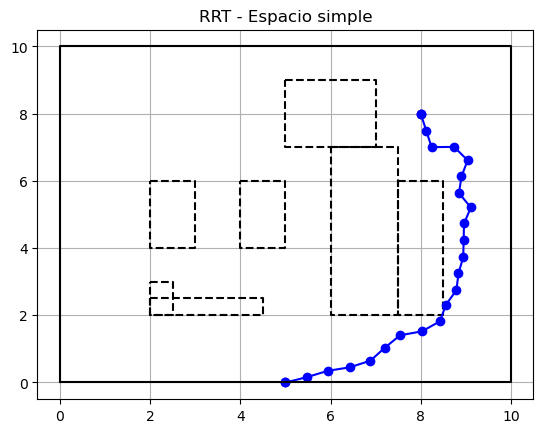

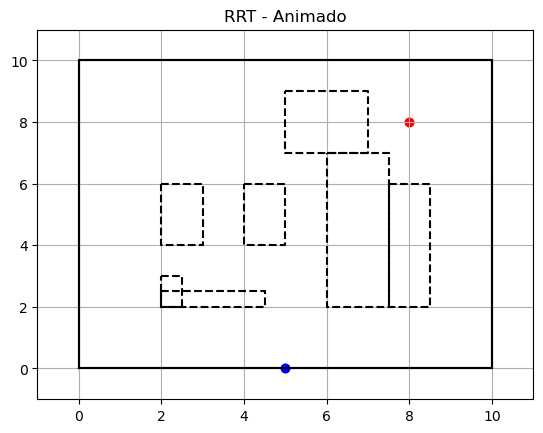

In [1713]:
ejecutar_RRT()